# Оценка перспективности региона разработки нефтяных месторождений

## Цель проекта:

Оценить перспективность разработки месторождений в одном из 3 представленных регионов, основываясь на показателях средней прибыли и вероятности возникновения убытков.

Импортируем библиотеки и посмотрим на имеющиеся у нас данные.

### Библиотеки

In [1]:
import pandas as pd
import math
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression

# 1. Загрузка и подготовка данных

Несмотря на знакомые (и даже близкие сердцу показатели - прибыль, модель машинного обучение, бюджет и т.д.), пути решения задачи для меня не очевидны. Поэтому, в первую очередь, посмотрим на имеющиеся данные и подумаем, как и какими способами мы можем с ними справиться.

In [2]:
oil_field_0 = pd.read_csv('/datasets/geo_data_0.csv')
oil_field_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [3]:
oil_field_1 = pd.read_csv('/datasets/geo_data_1.csv')
oil_field_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [4]:
oil_field_2 = pd.read_csv('/datasets/geo_data_2.csv')
oil_field_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Первое, на что стоит обратить внимание - столбец с ID-наименованием скважины. В нашем проекте данный столбец не имеет смысла, т.к. нам необходимо осуществить именно СТАТИСТИЧЕСКОЕ определение лучшего региона для "развития". Поэтому "точное название" месторождений нас не особо интересует. Удалим данный столбец из всех имеющихся датасетов.

In [5]:
oil_field_0_clean = oil_field_0.drop(['id'], axis = 1)
oil_field_1_clean = oil_field_1.drop(['id'], axis = 1)
oil_field_2_clean = oil_field_2.drop(['id'], axis = 1)

print(oil_field_0_clean.shape)
print(oil_field_1_clean.shape)
print(oil_field_2_clean.shape)

(100000, 4)
(100000, 4)
(100000, 4)


Столбца больше нет нигде, продолжаем. Также проверим данные на наличие пропусков и характер распределения имеющихся значений.

In [6]:
oil_field_0_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4)
memory usage: 3.1 MB


In [7]:
oil_field_1_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4)
memory usage: 3.1 MB


In [8]:
oil_field_2_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4)
memory usage: 3.1 MB


Пропусков в объектах нет. Строим кривую распределения для различных параметров.

In [9]:
def stat_values(data):
    print(data.min(), data.max())

stat_values(oil_field_0_clean['f0'])
stat_values(oil_field_1_clean['f0'])
stat_values(oil_field_2_clean['f0'])

-1.4086053060269959 2.3623308108542243
-31.60957601916769 29.42175461390372
-8.760003624213763 7.23826247979405


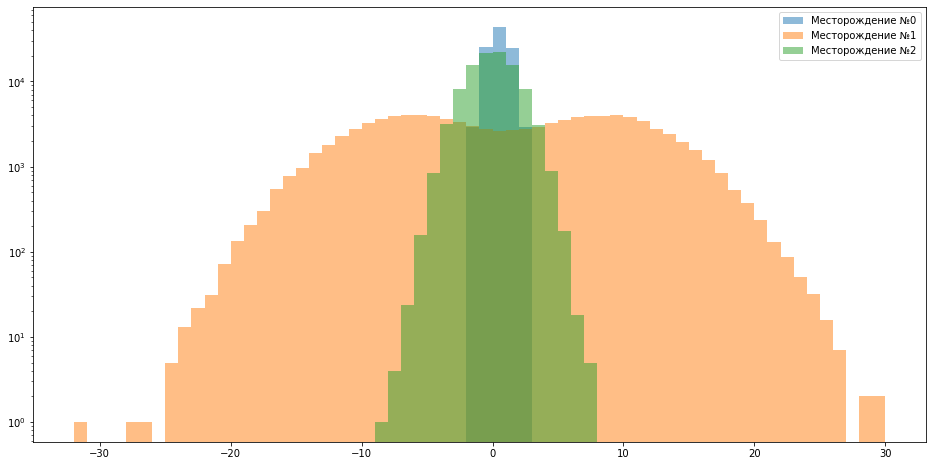

In [10]:
plt.figure(figsize=(16, 8))
plt.hist(oil_field_0_clean['f0'], bins = 62, range = (-32,30), alpha = 0.5, log = True)
plt.hist(oil_field_1_clean['f0'], bins = 62, range = (-32,30), alpha = 0.5, log = True)
plt.hist(oil_field_2_clean['f0'], bins = 62, range = (-32,30), alpha = 0.5, log = True)
plt.legend(['Месторождение №0', 'Месторождение №1', 'Месторождение №2'])

Диапазон варьирования параметра №0 существенно различается в зависимости от номера месторождения. Посмотрим на распределения других базовых параметров.

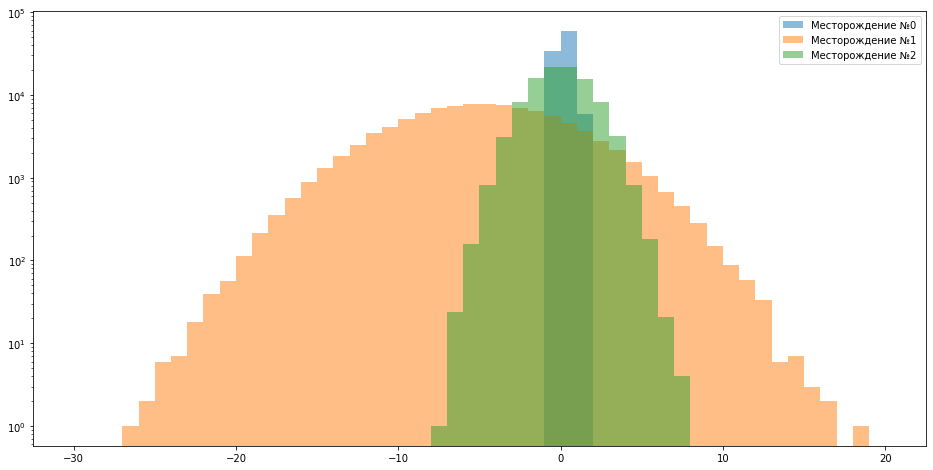

In [11]:
plt.figure(figsize=(16, 8))
plt.hist(oil_field_0_clean['f1'], bins = 50, range = (-30,20), alpha = 0.5, log = True)
plt.hist(oil_field_1_clean['f1'], bins = 50, range = (-30,20), alpha = 0.5, log = True)
plt.hist(oil_field_2_clean['f1'], bins = 50, range = (-30,20), alpha = 0.5, log = True)
plt.legend(['Месторождение №0', 'Месторождение №1', 'Месторождение №2'])

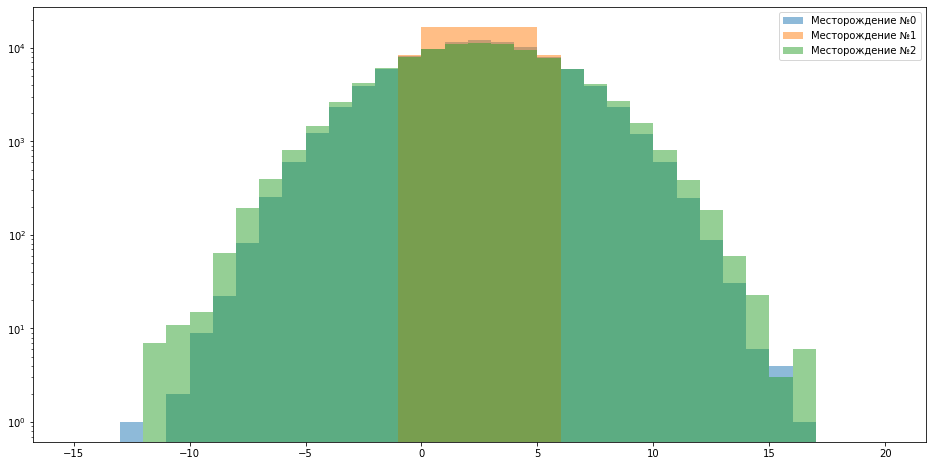

In [12]:
plt.figure(figsize=(16, 8))
plt.hist(oil_field_0_clean['f2'], bins = 35, range = (-15,20), alpha = 0.5, log = True)
plt.hist(oil_field_1_clean['f2'], bins = 35, range = (-15,20), alpha = 0.5, log = True)
plt.hist(oil_field_2_clean['f2'], bins = 35, range = (-15,20), alpha = 0.5, log = True)
plt.legend(['Месторождение №0', 'Месторождение №1', 'Месторождение №2'])

Очевидно, что даже на основе "входных" признаков, местоположения "существенно" отличаются. Проверим распределение целового признака - запасов.

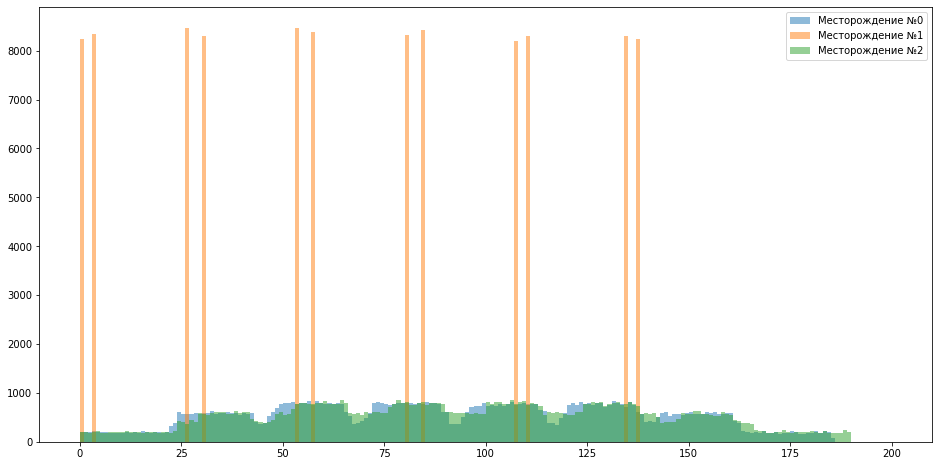

In [13]:
plt.figure(figsize=(16, 8))
plt.hist(oil_field_0_clean['product'], bins = 200, range = (0,200), alpha = 0.5)
plt.hist(oil_field_1_clean['product'], bins = 200, range = (0,200), alpha = 0.5)
plt.hist(oil_field_2_clean['product'], bins = 200, range = (0,200), alpha = 0.5)
plt.legend(['Месторождение №0', 'Месторождение №1', 'Месторождение №2'])

Распределение значений целевого признака в месторождениях №0 и №2 примерно одинаково - как по максимальному значению, так и по "групповому" распределению. На гистограмме можно выделить 6 "пиковых" значений, вокруг которых значения "емкости месторождения" распредлены нормально. Вероятно, человек разбирающийся в отрасли, даже сможет их как-то "назвать" и сделать некоторые выводы УЖЕ  на основании имеющихся данных.

Значения целевого признака месторождения №1 выглядят "нестандратно". 12 групп - (0,1), ... (134,135) и (137,138). Вероятно, причины такого распределения связаны с различными способами расчета (получения) информации относительно запасов. Также, возможна ошибка при сборе данных. На данном этапе у нас нет возможности уточнить этот вопрос, поэтому - работаем с тем, что есть.

"Разрежем" выборку на датасеты с признаками и целевым признаком. 

In [14]:
field_0_features = oil_field_0_clean.drop(['product'], axis = 1)
field_1_features = oil_field_1_clean.drop(['product'], axis = 1)
field_2_features = oil_field_2_clean.drop(['product'], axis = 1)

field_0_target = oil_field_0_clean['product']
field_1_target = oil_field_1_clean['product']
field_2_target = oil_field_2_clean['product']

print(field_0_features.shape)
print(field_0_target.shape)

(100000, 3)
(100000,)


# 2. Обучение и проверка модели

Регионов 3, они одинаковы (в том смысле, что нет исходных причин для того, чтобы "обучать" по их данным различные модели ML). 
Нам потребуется функция, которая будет:
1. Делить выборку на обучающую и валидационную
2. Обучать модель
3. Находить прогнозируемые значения целевого признака
4. Найти расчетные значения - средний запас по месторождениям в регионе и rmse
5. Добавить строчку с расчетными значениями и номером региона в таблицу

В качестве входных данных функция будет получать 2 датасета, содержащих значения входных и целевого признаков, + наименование региона.

In [15]:
def oil_field_model_predict(features, target, field_name):
    features_train, features_valid, target_train, target_valid = train_test_split(features, target,
                                                                test_size = 0.25, random_state = 11111)
    model_linreg = LinearRegression()
    model_linreg.fit(features_train, target_train)
    
    predicted_valid = model_linreg.predict(features_valid)
    rmse = mean_squared_error(target_valid, predicted_valid) ** 0.5
    
    mean_reserve = predicted_valid.mean()
    
    compar_table.loc[field_name ,'rmse'] = rmse
    compar_table.loc[field_name ,'mean_reserve'] = mean_reserve
    
    return predicted_valid

Создадим таблицу, в которую мы планируем добавлять интересующие нас расчетные параметры. И "раскрутим" нашу функцию трижды. 

In [16]:
column = ["rmse", "mean_reserve"]
compar_table = pd.DataFrame(columns = column)

predicted_valid_0 = oil_field_model_predict(field_0_features, field_0_target, "field_0")
predicted_valid_1 = oil_field_model_predict(field_1_features, field_1_target, "field_1")
predicted_valid_2 = oil_field_model_predict(field_2_features, field_2_target, "field_2")
compar_table

,rmse,mean_reserve
field_0,37.8013,92.6022
field_1,0.892881,69.4202
field_2,40.2343,94.935


Что мы получили?

1. С точки зрения наибольших средних запасов, первое место с небольшим перевесом занимает регион №2, на втором месте - регион №0. Регион №1 "не стоит и рядом" - среднее значение запаса там гораздо ниже - почти на треть, по сравнению с "лидерами".
2. А вот с точки зрения значений корня из среднеквадратической ошибки, наивысшая точность прогнозирования, напротив, у месторождений региона №1. Что мы и наблюдали ранее, когда анализировали распределение значений. В случае региона №1 это 12 групп, с диапазоном варьирования 1 тыс. баррелей, что существенно отличается от логики распределения запасов для регионов №0 и 2. Таким образом, различие в rmse, скорее указывает на расхождение и, возможно, ошибку в исходных данных, нежели на высокую точность прогнозирования. 

# 3. Подготовка к расчёту прибыли

Что нам нужно знать для расчета прибыли?
1. Цену бурения - 50 миллионов;
2. Цена "выбуренного" барреля нефти - 4500 рублей;
3. Число точек "пробного" бурения региона - 500 шт;
4. Количество повторения - 1000 раз;
5. Общий бюджет на разработку месторождений - 10 000 000 000 рублей (10 в 10й степени рублей)

In [17]:
barrel_profit = 4500
drill_price = 50000000
bootstrap_size = 500
bootstrap_number = 1000
field_drill_budget = 10000000000
max_drill_number = int(field_drill_budget / drill_price)

Теперь нам необходимо подсчитать минимальный средний объём сырья в месторождениях региона, достаточный для его разработки. Поскольку разницы в стоимости барреля, цене разработки 1 месторождения и других параметров нет, данное значение будет общим для всех регионов. Эдакий, порог входа в регион. 

Минимальный средний объем сырья в месторождениях - тот, при котором мы не получаем ни выгоды, ни убытка - т.е. доход от месторождения должен полностью покрывать цену бурения в данной точке.

In [18]:
min_mean_reserve = math.ceil(drill_price / barrel_profit)
print("Минимальный средний объем сырья в месторождения региона, достаточный для его разработки, составляет",
      min_mean_reserve / 1000, "тысяч баррелей.")

Минимальный средний объем сырья в месторождения региона, достаточный для его разработки, составляет 11.112 тысяч баррелей.


Пороговое значение "выгодных" месторождений есть, теперь напишем функцию для расчета прибыли.

В условиях задачи есть дополнение "по набору отобранных месторождений и предсказаний модели", однако, я не совсем понимаю, как это сделать - поэтому функция просто будет рассчитывать прибыль. В дальнейшем, в качестве "материала для работы" воспользуемся датасетом предсказаний "запасов" по валидационным данным.

Итак, теперь всё стало предельно ясно. Помня про то, что у нас есть бюджет в 10 млрд. рублей (которого хватит на разработку 200 месторождений), мы может наконец нормально посчитать прибыль от разработки месторождений.
1. Исследовали 500 точек (получили соотв. выборку)
2. Из них выбираем 200 точек с наибольшим ПРОГНОЗНЫМ значением
3. Прибыль рассчитываем же по РЕАЛЬНЫМ значениям запасов. Если по прогнозу запас равен 100 единицам, а в реальности - 10, то прибыль будет рассчитываться от 10 единиц, а не от 100. 
4. Добавляем полученное значение в массив и повторем это 1000 раз.

Итого - массив на 1000 значений СУММАРНОЙ прибыли от 200 НАИЛУЧШИХ ПРОГНОЗНЫХ точек, рассчитанной по значениям РЕАЛЬНЫХ запасов.

In [19]:
def profit_calc(predicted_reserve_sample, target_reserve_sample):
    probs = predicted_reserve_sample.sort_values(ascending = False)
    probs_200 = probs[:200]
    target_200 = target_reserve_sample[probs_200.index]
    profit = target_200.sum() * barrel_profit * 1000 - field_drill_budget
    
    return profit

Переходим к расчету распределения прибыли в каждом из представленных регионов. 

# 4. Расчёт прибыли и рисков 

In [20]:
state = np.random.RandomState(11111)

def region_finder(reserve_data, target_data):
    profit = []
    
    for i in range(bootstrap_number):
        
#         здесь определяем среднюю сумму заработка
        probs = reserve_data.sample(n = bootstrap_size, replace = True, random_state = state)
        profit.append(profit_calc(probs, target_data))
             
    return profit

Функция готова. Реализуем её на примере имеющихся датасетов для 3 регионов и занесем полученные значения в итоговую таблицу.

In [21]:
final_table = pd.DataFrame(columns = ['mean_profit', 'loss_risk', 'q_2.5', 'q_97.5'])

def final_table_fill(predicted_dataset, target_data, i):
    
    predicted_df = pd.Series(predicted_dataset)
    profit_region = region_finder(predicted_df, target_data)
    
    profit_region_series = pd.Series(profit_region)
    final_table.loc[i,'mean_profit'] = profit_region_series.mean()
    
    final_table.loc[i,'loss_risk'] = profit_region_series[profit_region_series < 0].count() * 100 / profit_region_series.count()
    final_table.loc[i,'q_2.5'] = profit_region_series.quantile(0.025)
    final_table.loc[i,'q_97.5'] = profit_region_series.quantile(0.975)
 
        
    return final_table

In [22]:
%%time
final_table_fill(predicted_valid_0, field_0_target, 0)
final_table_fill(predicted_valid_1, field_1_target, 1)
final_table_fill(predicted_valid_2, field_2_target, 2)

CPU times: user 6.73 s, sys: 0 ns, total: 6.73 s
Wall time: 6.78 s


,mean_profit,loss_risk,q_2.5,q_97.5
0,7.36674e+10,0,6.7795e+10,7.91447e+10
1,5.07918e+10,0,4.48833e+10,5.65077e+10
2,7.54449e+10,0,7.01555e+10,8.10501e+10


## Выводы

Согласно полученным значениям целевых показателей, дальнейшую разработку рекомендуется проводить в регионе №2. 

Это обусловлено большей средней выручкой на 200 разрабатываемых точек по сравнению со значениями, полученными для регионов 0 и 1. 

Риска возникновения убытков (статистически) для всех исследованных регионов нет.